In [1]:
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime 

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LassoCV

In [3]:
root = 'D:/Jupyterfiles/ThermalData/2021-01/'
file_paths = os.listdir(root)

data = pd.read_excel(os.path.join(root, file_paths[0]))
for i in range(1, len(file_paths)):
    single_file_data = pd.read_excel(os.path.join(root, file_paths[i]))
    data = pd.merge(data, single_file_data, how='left', on=['时间'])

### 数据处理

In [59]:
internal_factors = ['10MKA10CE301XQ01', '10MKA10CE301XQ02', '10MKA10CE101XQ01', '10MKA10CE101XQ02', '10MKA10CE101XQ03',
                  '10MKF30CT302', '10MKG10CT301', '10MKG10CT303', '10MKG10CT305', '10MKG10CT307']

external_factors = ['10MKA01CT301','10MKA01CT303','10MKA01CT305','10MKA01CT307','10MKA01CT309','10MKA01CT311',
                    '10MKA01CT313','10MKA01CT315','10MKA01CT317','10MKA01CT319','10MKA01CT321','10MKA01CT323',
                    '10MKA01CT325','10MKA01CT327','10MKA01CT329','10MKA01CT331','10MKA01CT333','10MKA01CT335',
                    '10MKA01CT337','10MKA01CT339','10MKA01CT341','10MKA01CT343','10MKA01CT345','10MKA01CT347',
                    '10MKA01CT349','10MKA01CT351','10MKA01CT353','10MKA01CT355','10MKA01CT357','10MKA01CT359',
                    '10MKA01CT361','10MKA01CT363','10MKA01CT365','10MKA01CT367','10MKA01CT369','10MKA01CT371','10MKA01CT373',
                    '10MKA01CT375','10MKA01CT377','10MKA01CT379','10MKA01CT381','10MKA01CT383','10MKA01CT601','10MKA01CT602',
                    '10MKA01CT603','10MKA01CT604','10MKA01CT605','10MKA01CT606','10MKA01CT607','10MKA01CT608','10MKA01CT609',
                    '10MKA01CT610','10MKA01CT611','10MKA01CT612','10MKA01CT613','10MKA01CT614','10MKA01CT615','10MKA01CT616',
                    '10MKA01CT617','10MKA01CT618']

target_column=['10MKA01CT607']
target_column

['10MKA01CT607']

In [5]:
# 数据类型更改和校验、数据拼接
data['时间'] = pd.to_datetime(data['时间'])
data = data.infer_objects()
data.columns =[col.strip() for col in data.columns]
internal_factors = list(map(str.strip, internal_factors))
external_factors = list(map(str.strip, external_factors))
target_column = list(map(str.strip, target_column))
df = data[list(set(['时间'] + internal_factors + external_factors + target_column))]
df

,10MKA01CT607,10MKA01CT604,10MKA01CT609,10MKA01CT337,10MKA01CT317,10MKA01CT311,10MKA01CT375,10MKA01CT325,10MKA01CT361,10MKA01CT383,...,10MKA01CT602,10MKA01CT323,10MKA01CT611,10MKA01CT365,10MKA01CT331,10MKA01CT339,10MKF30CT302,10MKA01CT301,10MKA01CT603,10MKA01CT341
0,42.468188,48.507393,42.954588,49.343246,49.470055,49.216446,49.343246,49.343246,52.641781,48.582512,...,45.947723,48.455738,46.484333,49.470055,48.455738,49.330566,40.782337,48.542645,45.648443,49.596863
1,42.734612,47.861877,43.162907,49.596863,49.596863,49.387629,49.470055,49.546140,52.768715,48.836071,...,45.736603,48.582512,46.415355,49.596863,48.582512,49.470055,41.111195,48.834506,45.425684,49.723679
2,42.487389,48.228597,42.915893,49.850502,49.977325,49.723679,49.723679,49.850502,53.149540,49.089649,...,46.139359,48.962856,46.204427,49.977325,48.836071,49.850502,41.743710,49.177155,45.736603,50.104156
3,42.742216,47.938188,43.239925,49.850502,49.850502,49.723679,49.723679,49.850502,53.022594,49.089649,...,45.836250,48.836071,46.468895,49.850502,48.836071,49.723679,41.743710,49.177155,45.525391,50.104156
4,42.298000,47.674488,42.842457,49.089649,49.089649,48.962856,48.962856,48.962856,52.134102,48.328972,...,45.698115,48.202209,45.820793,49.089649,48.075451,48.962856,41.617195,48.415760,45.295003,49.292526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,44.507614,51.210575,45.222584,52.134102,52.261017,52.007195,52.134102,52.134102,55.689495,51.245850,...,48.984791,51.042851,47.785886,52.134102,50.992104,52.007195,43.262230,51.589413,49.007668,52.387932
1485,44.726824,50.990218,45.395409,51.880291,52.134102,51.753391,52.007195,51.880291,55.562450,51.118973,...,48.740593,50.865242,47.957845,52.007195,50.865242,51.880291,43.009094,51.462406,48.797813,52.134102
1486,44.842159,51.081364,45.510593,51.880291,52.134102,51.880291,52.007195,51.880291,55.562450,51.118973,...,48.889347,50.865242,48.072451,52.007195,50.865242,51.829531,43.009094,51.462406,48.969429,52.134102
1487,44.434412,51.252224,45.149487,51.880291,52.007195,51.753391,51.880291,51.880291,55.562450,50.992104,...,49.003744,50.865242,47.713154,51.880291,50.738380,51.753391,43.009094,51.335407,49.026623,52.134102


In [6]:
# 根据启机条件筛选数据、缺失值填充
df = df.query("`10MKA10CE301XQ01` > 50")
df = df.fillna(df.mean()).reset_index(drop=True)
df 

,10MKA01CT607,10MKA01CT604,10MKA01CT609,10MKA01CT337,10MKA01CT317,10MKA01CT311,10MKA01CT375,10MKA01CT325,10MKA01CT361,10MKA01CT383,...,10MKA01CT602,10MKA01CT323,10MKA01CT611,10MKA01CT365,10MKA01CT331,10MKA01CT339,10MKF30CT302,10MKA01CT301,10MKA01CT603,10MKA01CT341
0,42.468188,48.507393,42.954588,49.343246,49.470055,49.216446,49.343246,49.343246,52.641781,48.582512,...,45.947723,48.455738,46.484333,49.470055,48.455738,49.330566,40.782337,48.542645,45.648443,49.596863
1,42.734612,47.861877,43.162907,49.596863,49.596863,49.387629,49.470055,49.546140,52.768715,48.836071,...,45.736603,48.582512,46.415355,49.596863,48.582512,49.470055,41.111195,48.834506,45.425684,49.723679
2,42.487389,48.228597,42.915893,49.850502,49.977325,49.723679,49.723679,49.850502,53.149540,49.089649,...,46.139359,48.962856,46.204427,49.977325,48.836071,49.850502,41.743710,49.177155,45.736603,50.104156
3,42.742216,47.938188,43.239925,49.850502,49.850502,49.723679,49.723679,49.850502,53.022594,49.089649,...,45.836250,48.836071,46.468895,49.850502,48.836071,49.723679,41.743710,49.177155,45.525391,50.104156
4,42.298000,47.674488,42.842457,49.089649,49.089649,48.962856,48.962856,48.962856,52.134102,48.328972,...,45.698115,48.202209,45.820793,49.089649,48.075451,48.962856,41.617195,48.415760,45.295003,49.292526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,44.507614,51.210575,45.222584,52.134102,52.261017,52.007195,52.134102,52.134102,55.689495,51.245850,...,48.984791,51.042851,47.785886,52.134102,50.992104,52.007195,43.262230,51.589413,49.007668,52.387932
1485,44.726824,50.990218,45.395409,51.880291,52.134102,51.753391,52.007195,51.880291,55.562450,51.118973,...,48.740593,50.865242,47.957845,52.007195,50.865242,51.880291,43.009094,51.462406,48.797813,52.134102
1486,44.842159,51.081364,45.510593,51.880291,52.134102,51.880291,52.007195,51.880291,55.562450,51.118973,...,48.889347,50.865242,48.072451,52.007195,50.865242,51.829531,43.009094,51.462406,48.969429,52.134102
1487,44.434412,51.252224,45.149487,51.880291,52.007195,51.753391,51.880291,51.880291,55.562450,50.992104,...,49.003744,50.865242,47.713154,51.880291,50.738380,51.753391,43.009094,51.335407,49.026623,52.134102


In [54]:
# 根据时间区分训练集（"时间 < '2021-01-22 00:00:00'"）、
# 验证集（"时间 >= '2021-01-22 00:00:00' & 时间 < '2021-01-27 00:00:00'"）、
# 测试集（"时间 >= '2021-01-27 00:00:00'"）
df_train = df.query("时间 < '2021-01-28 00:00:00'").reset_index(drop=True)
df_val = df.query("时间 >= '2021-01-28 00:00:00' & 时间 < '2021-01-30 00:00:00'").reset_index(drop=True)
df_test = df.query("时间 >= '2021-01-30 00:00:00'").reset_index(drop=True)

In [55]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1296, 71)
(96, 71)
(97, 71)


In [10]:
# 查看target_column， 不能在train_cols里面
# target_column[0] in train_cols

In [11]:
# clf = KNN(contamination=0.05)
# clf.fit(df_train[train_cols]) # 使用X_train训练检测器clf
# y_train_pred = clf.labels_  # 返回训练数据上的分类标签 (0: 正常值, 1: 异常值)
# y_train_scores = clf.decision_scores_  # 返回训练数据上的异常值 (分值越大越异常)
# df_train['y_train_pred'] = y_train_pred
# df_train['y_train_scores'] = y_train_scores
# df_training = (df_train[df_train['y_train_pred']==0]
#                         .drop(['y_train_pred', 'y_train_scores'], axis=1)
#                         .reset_index(drop=True))
# print(df_training.shape)

### 提取特征

In [98]:
def convert_realtime_data(data, target_column, window_size):
    df_real_time = data.copy()
    new_elements = df_real_time.columns.tolist()
    new_elements.remove("时间")
    new_elements.remove(target_column[0])
    
    # 每个变量都进行shift
    shift_cols = []
    shift_col_names = []
    for i in range(len(new_elements)):
        for window in window_size:
            shift_cols.append(df_real_time[new_elements[i]].shift(window))
            shift_col_names.append(f'{new_elements[i]}_{window}')
    
    # 按照rolling_window计算统计特征
    stats_cols = []
    stats_col_names = []
    for window in window_size[:-2]:
        f_min = lambda x: x.rolling(window=window).min()
        f_max = lambda x: x.rolling(window=window).max()
        f_mean = lambda x: x.rolling(window=window).mean()
        f_std = lambda x: x.rolling(window=window).std()
        f_median = lambda x: x.rolling(window=window).median()
        f_skew = lambda x:x.rolling(window=window).skew()
        function_list = [f_min, f_max, f_mean, f_std, f_median, f_skew]
        function_name = ['min', 'max', 'mean', 'std', 'median', 'skew']
        for k in range(len(function_list)):
            stats_cols.append(df_real_time[new_elements].apply(function_list[k]))
            stats_col_names.extend(pd.Series(df_real_time[new_elements].columns)
                                   .apply(lambda x:x+str(f'_{window}_{function_name[k]}')).tolist())
    
    x_shift = pd.concat(shift_cols, axis=1)
    x_shift.columns = shift_col_names
    
    x_stats = pd.concat(stats_cols, axis=1)
    x_stats.columns = stats_col_names
    
    df_real_time = pd.concat([df_real_time, x_shift, x_stats], axis=1)
    
    # 提取时间性的特征
    df_real_time['Day'] = df_real_time['时间'].dt.day
    df_real_time['DayOfWeek'] = df_real_time['时间'].dt.dayofweek
    df_real_time['Hour'] = df_real_time['时间'].dt.hour 
    df_real_time['minute'] = df_real_time['时间'].dt.minute 

    df_real_time = df_real_time.dropna(axis=0, how='any').reset_index(drop=True)
    return df_real_time

In [100]:
df_train_featured = convert_realtime_data(df_train, target_column, [5,4,3,2,1])

df_val_featured = convert_realtime_data(df_val, target_column, [5,4,3,2,1])

df_test_featured = convert_realtime_data(df_test, target_column, [5,4,3,2,1])

In [101]:
print(df_train_featured.shape)
print(df_val_featured.shape)
print(df_test_featured.shape)

(1291, 1662)
(91, 1662)
(92, 1662)


### 特征选择+模型训练+实时预测

In [102]:
train_cols = df_train_featured.columns.tolist()
train_cols.remove('时间') 
train_cols.remove(target_column[0])

In [103]:
target_column[0] in train_cols

False

In [104]:
x_train, y_train = df_train_featured[train_cols], df_train_featured[target_column]
x_val, y_val = df_val_featured[train_cols], df_val_featured[target_column]
x_test, y_test = df_test_featured[train_cols], df_test_featured[target_column]

In [105]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1291, 1660)
(91, 1660)
(92, 1660)


In [108]:
# #递归特征消除法，返回特征选择后的数据
# #参数estimator为基模型
# #参数n_features_to_select为选择的特征个数
# RFE(estimator=RandomForestRegressor(), n_features_to_select=2).fit_transform(x_train.values, y_train.values)

# from sklearn.feature_selection import SelectKBest #常用的特征选择的函数
# from sklearn.feature_selection import chi2

#选择K=2个最好的特征，返回选择特征后的数据
# X_new = SelectKBest(chi2, k=int(x_train.shape[1]*0.7)).fit_transform(x_train.values, y_train.values)

# # 特征选择
# sel = VarianceThreshold(threshold=0.6)
# x_train_new = sel.fit_transform(x_train)
# model_selected_columns = x_train.columns[sel.get_support()]

In [106]:
# 特征选择
# reg = LassoCV(n_jobs=-1)
reg = RandomForestRegressor(n_jobs=-1) 
reg.fit(x_train.values, y_train.values) 
feature_model = SelectFromModel(reg, prefit=True, max_features=int(x_train.shape[1]*0.8))
x_train_new = feature_model.transform(x_train)
model_selected_columns = x_train.columns[feature_model.get_support()]
print("选择的特征是：", model_selected_columns)
print("特征选择后的数据：", x_train_new.shape)

选择的特征是： Index(['10MKA01CT609', '10MKG10CT305', '10MKG10CT303', '10MKA01CT610',
       '10MKA01CT608', '10MKA01CT612', '10MKA01CT611', '10MKA01CT609_1',
       '10MKA01CT608_1', '10MKA01CT609_5_min', '10MKG10CT305_5_min',
       '10MKG10CT303_5_min', '10MKA01CT610_5_min', '10MKA01CT608_5_min',
       '10MKA01CT611_5_min', '10MKA01CT609_5_max', '10MKG10CT305_5_max',
       '10MKG10CT303_5_max', '10MKG10CT307_5_max', '10MKA01CT609_5_mean',
       '10MKG10CT303_5_mean', '10MKA01CT608_5_mean', '10MKG10CT303_5_median',
       '10MKA01CT609_4_min', '10MKG10CT305_4_min', '10MKG10CT301_4_min',
       '10MKG10CT303_4_min', '10MKA01CT610_4_min', '10MKA01CT608_4_min',
       '10MKA01CT611_4_min', '10MKG10CT305_4_max', '10MKG10CT303_4_max',
       '10MKG10CT307_4_max', '10MKA01CT608_4_max', '10MKG10CT305_4_mean',
       '10MKG10CT303_4_mean', '10MKA01CT608_4_mean', '10MKA01CT611_4_mean',
       '10MKG10CT305_4_median', '10MKA01CT612_4_median',
       '10MKA01CT611_4_median', '10MKA01CT609_3_min', '

In [107]:
# 随机森林
pipe = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
('model', RandomForestRegressor())])
param_grid = {'model__n_estimators':[*range(10, 200, 10)],
              'model__max_depth':[*range(10, 60, 10)]}

# 网格搜索
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=-1) 
grid.fit(x_train_new, y_train.values)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=-999,
                                                      strategy='constant')),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, 30, 40, 50],
                         'model__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                                 90, 100, 110, 120, 130, 140,
                                                 150, 160, 170, 180, 190]})

In [108]:
# 在验证集上的结果(mape,r2,mae,mse)、真实值和预测值的最大差异
pred_val_value = grid.predict(x_val[model_selected_columns].values)
val_mape = mean_absolute_percentage_error(y_val.values, pred_val_value)
val_r2 = r2_score(y_val.values, pred_val_value)
val_mae = mean_absolute_error(y_val.values, pred_val_value)
val_mse = mean_squared_error(y_val.values, pred_val_value)
val_max_diff_value = max(abs(y_val.values.ravel() - pred_val_value))


# 在测试集上的结果(mape,r2,mae,mse)、真实值和预测值的最大差异
pred_test_value = grid.predict(x_test[model_selected_columns].values)
test_mape = mean_absolute_percentage_error(y_test.values, pred_test_value)
test_r2 = r2_score(y_test.values, pred_test_value)
test_mae = mean_absolute_error(y_test.values, pred_test_value)
test_mse = mean_squared_error(y_test.values, pred_test_value)
test_max_diff_value = max(abs(y_test.values.ravel() - pred_test_value))

In [109]:
res_featured = pd.DataFrame({ '因变量':target_column[0], 
                             'val_mape':val_mape, 'val_r2':val_r2, 'val_mae':val_mae, 'val_mse':val_mse, 
                             'val_max_diff_value':val_max_diff_value,
                            'test_mape':test_mape, 'test_r2':test_r2, 'test_mae':test_mae, 'test_mse':test_mse,
                            'test_max_diff_value':test_max_diff_value}, index=[1])

In [110]:
res_featured

,因变量,val_mape,val_r2,val_mae,val_mse,val_max_diff_value,test_mape,test_r2,test_mae,test_mse,test_max_diff_value
1,10MKA01CT607,0.001238,0.919405,0.055264,0.00488,0.216005,0.002094,0.846331,0.093586,0.01233,0.316097


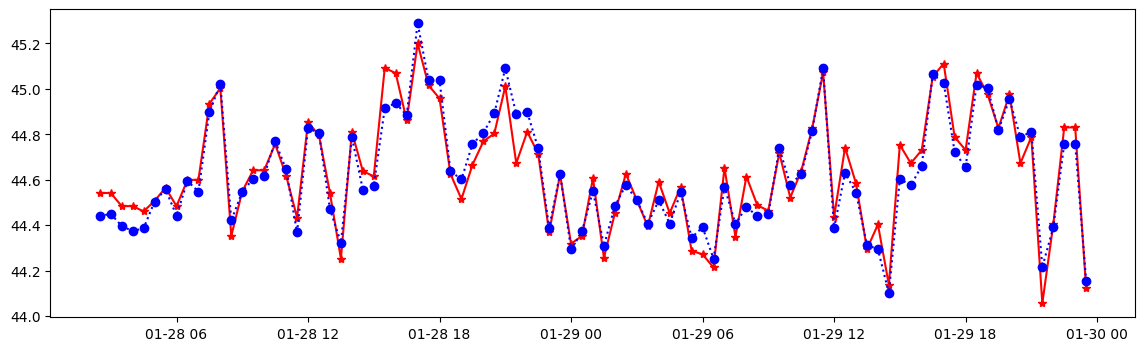

In [120]:
plt.figure(figsize=(14, 4))
plt.plot(df_val_featured['时间'], df_val_featured[target_column], c='red', marker='*', linestyle='-', label=df_val_featured[target_column])
plt.plot(df_val_featured['时间'], pred_val_value, c='blue', marker='o', linestyle=':', label='pred')

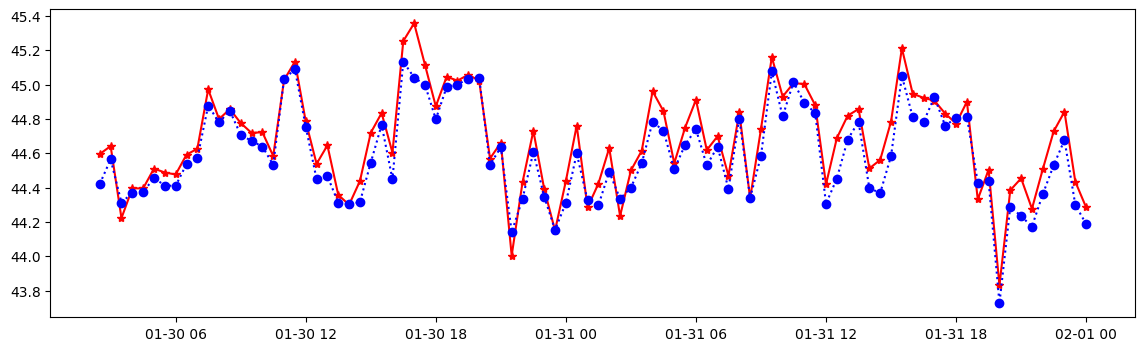

In [121]:
plt.figure(figsize=(14, 4))
plt.plot(df_test_featured['时间'], df_test_featured[target_column], c='red', marker='*', linestyle='-', label=df_test_featured[target_column])
plt.plot(df_test_featured['时间'], pred_test_value, c='blue', marker='o', linestyle=':', label='pred')